The Plan is to create Two Models: 
 1. Model predicting monthly sales for a category_id
 2. Model predicting monthly sales for a shop_id

And then to combine both models to create 
 3. Model predicting monthly sales given category_id and shop_id.

Previous attempt to use shop_id and item_id  was forfeited due to large training time required for 21807 unique item_id

*  Make ARIMA model
*  Make model according to graph type

# Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Datascience Projects/Sales Prediction Kaggle/"

In [ ]:
! kaggle competitions download 'competitive-data-science-predict-future-sales'

 99% 15.0M/15.1M [00:00<00:00, 156MB/s]
100% 15.1M/15.1M [00:00<00:00, 155MB/s]


In [ ]:
!unzip -q /content/competitive-data-science-predict-future-sales.zip -d .

# Loading Data

In [ ]:
df_sales = pd.read_csv('sales_train.csv')
df_cat = pd.read_csv('items.csv')
df = pd.merge(df_sales, df_cat, on='item_id', how='left')
cols = ['date', 'date_block_num', 'shop_id', 'item_name', 'item_id', 'item_price', 'item_category_id', 'item_cnt_day']
df = df[cols] # rearranging columns

df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(2935849, 8)


,date,date_block_num,shop_id,item_name,item_id,item_price,item_category_id,item_cnt_day
0,2013-02-01,0,59,ЯВЛЕНИЕ 2012 (BD),22154,999.00,37,1.0
1,2013-03-01,0,25,DEEP PURPLE The House Of Blue Light LP,2552,899.00,58,1.0
2,2013-05-01,0,25,DEEP PURPLE The House Of Blue Light LP,2552,899.00,58,-1.0
3,2013-06-01,0,25,DEEP PURPLE Who Do You Think We Are LP,2554,1709.05,58,1.0
4,2013-01-15,0,25,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),2555,1099.00,56,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_name         object        
 4   item_id           int64         
 5   item_price        float64       
 6   item_category_id  int64         
 7   item_cnt_day      float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 201.6+ MB


In [ ]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
df_sample = pd.read_csv('sample_submission.csv')
print(df_sample.shape)
df_sample.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


# Constants and Functions

In [ ]:
CATS = df['item_category_id'].unique()
SHOPS = df['shop_id'].unique()
MONTHS = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
CATS.sort()
SHOPS.sort()
print(CATS)
print(SHOPS)
print('CATS : ',CATS.size, ' SHOPS : ', SHOPS.size, ' MONTHS : ', len(MONTHS))

ORDER = (12,1,6) # (p,d,q) for ARIMA, this is an approximation, each cat or shop can have different ideals

SAVE_PATH = '/content/gdrive/MyDrive/Datascience Projects/Sales Prediction Kaggle/'

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
CATS :  84  SHOPS :  60  MONTHS :  34


In [ ]:
def rolling_ARIMA(data, train_size, order):
  '''
    data must be arraylike object
  '''
  forecast = []
  for i in range(train_size, len(data)):
    train = data[:i]
    model = ARIMA(train, order=order)
    result = model.fit()
    forecast.append(result.predict(start=i, end=i)[0])
  
  return result, forecast

def optimised_ARIMA(data, train_size, order_range, metric=mean_squared_error, model=rolling_ARIMA):
  '''
  data must be arraylike object
  '''
  order = None
  best_metric_val = np.inf
  best_result, best_forecast = 0,0
  # if verbose : print('(p,d,q) => metric')
  for p in order_range[0]:
    for d in order_range[1]:
      for q in order_range[2]:
        # if verbose : print((p,d,q), end=' => ')
        try:
          result, forecast = model(data, train_size, order=(p,d,q))
        except Exception as e:
          # if verbose : print(e)
          continue
        test = data[train_size:]
        # print(test, forecast)
        try:
          metric_val = metric(test, forecast)
        except ValueError as e:
          # if verbose : print(e)
          continue
        # if verbose : print(metric_val)
        if metric_val<best_metric_val:
          order = (p,d,q)
          best_metric_val = metric_val
          best_result, best_forecast =  result, forecast
  
  print('***best params***')
  print(order, '=>', best_metric_val)
  
  return best_result, best_forecast, best_metric_val, order

# Data Wrangling

We need to create models for each item_category_id and each shop_id

In [ ]:
# These two will be used to dynamically create datasets for model1 and model2
gb_cats = df.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum()
gb_shops = df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum()

In [ ]:
gb_cats

item_category_id  date_block_num
0                 0                   1.0
                  1                   1.0
                  3                   1.0
1                 0                   1.0
                  1                   1.0
                                    ...  
83                29                258.0
                  30                298.0
                  31                293.0
                  32                277.0
                  33                348.0
Name: item_cnt_day, Length: 2077, dtype: float64

In [ ]:
gb_shops

shop_id  date_block_num
0        0                 5578.0
         1                 6127.0
1        0                 2947.0
         1                 3364.0
2        0                 1146.0
                            ...  
59       29                 913.0
         30                 992.0
         31                1214.0
         32                 914.0
         33                 790.0
Name: item_cnt_day, Length: 1586, dtype: float64

# EDA

In [ ]:
# fig, ax = 

# Model 1

In [ ]:
# #uncomment this block to create file from scratch
# with open(SAVE_PATH+'cats.txt', 'w') as f:
#   pass

train_size = 29
test_size = 3
x = MONTHS
x_train = x[:train_size]
x_test = x[train_size : train_size + test_size]
x_val = x[train_size + test_size : ]

0 0
***best params***
(6, 2, 0) => 5.694003492189845e-131
1 1
***best params***
(6, 1, 0) => 1.6972115325725293e-162
2 2
***best params***
(6, 2, 6) => 1030.6698854916165
3 3
***best params***
(12, 0, 0) => 18932.972478563086
4 4
***best params***
(6, 1, 6) => 0.9999989239053496
5 5
***best params***
(6, 2, 6) => 803.5931844751832
6 6
***best params***
(12, 1, 0) => 3617.0106038348968
7 7
***best params***
(6, 0, 0) => 10159.965301162832
8 8
***best params***
(6, 1, 3) => 11348.540557713766
9 9
***best params***
(12, 1, 3) => 157298.4528113239
10 10
***best params***
(6, 1, 3) => 7.351616991820733e-150
11 11
***best params***
(6, 1, 6) => 50.00005020652884
12 12
***best params***
(6, 2, 3) => 3886.5634041482845
13 13
***best params***
(6, 2, 0) => 2.0354248318024684e-32
14 14
***best params***
(12, 2, 0) => 250.95469316745425
15 15
***best params***
(6, 2, 6) => 97.9976093579481
16 16
***best params***
(12, 1, 6) => 471.0010156109144
17 17
***best params***
(6, 1, 0) => 0.1602310356860

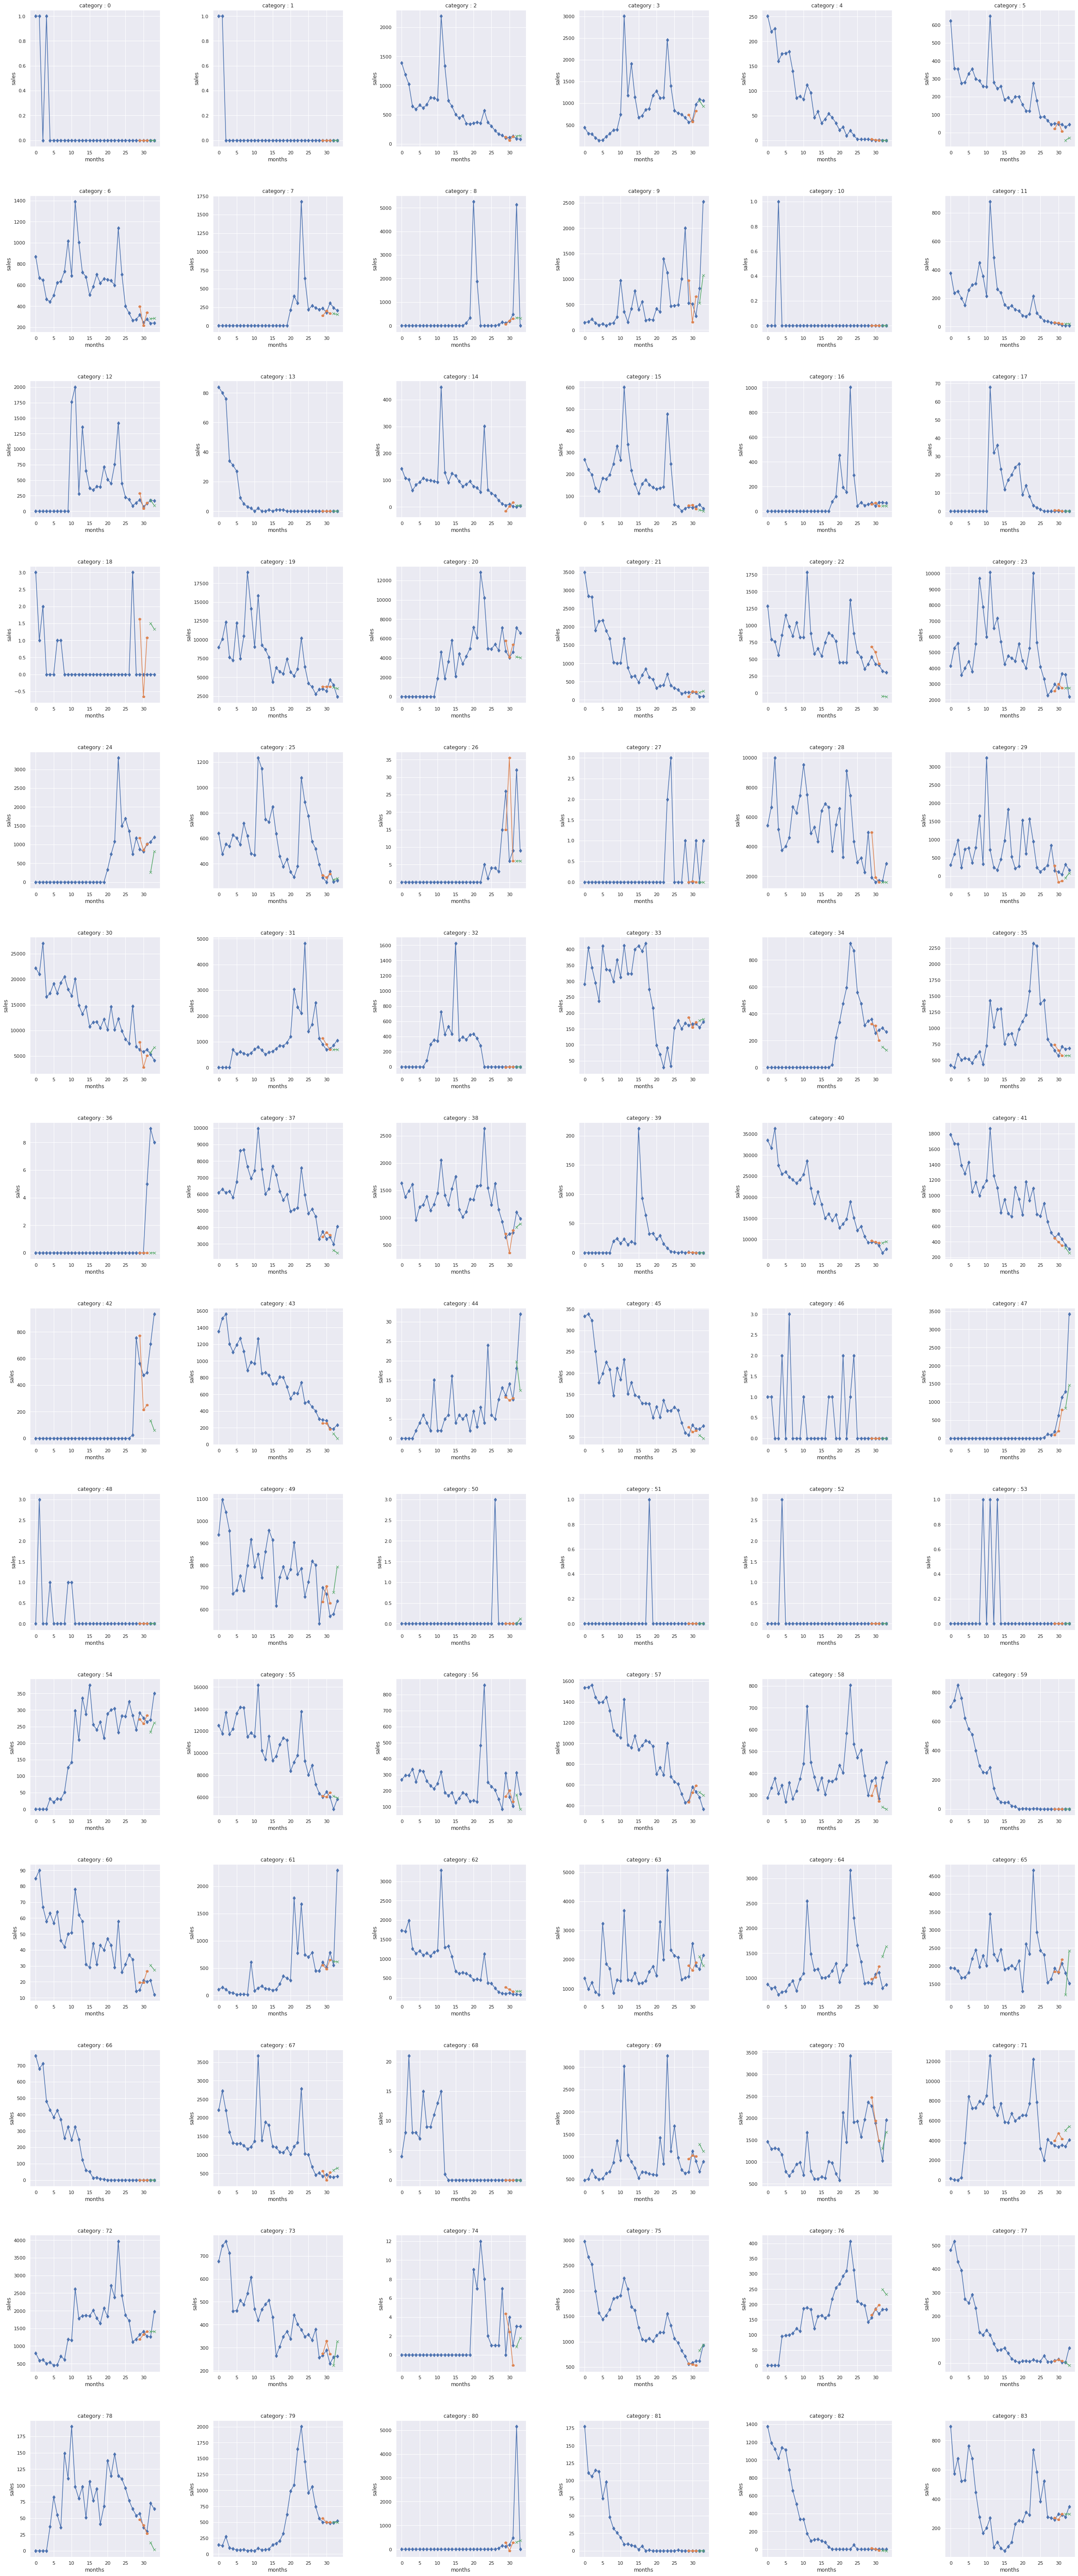

In [ ]:
# 84 cats vs 34 months
k = 6 # scale of plot
n, m = 14,6 # matrix of graphs
fig, axes = plt.subplots(n,m, figsize=(m*k,n*k))

cats_ARIMA = []

num_months = len(x)
for i,cat in enumerate(CATS):
  print(i,cat)
  y = np.zeros(num_months)
  y[gb_cats[cat].index] = gb_cats[cat].values

  y_train = y[:train_size]
  y_test = y[train_size : train_size + test_size]
  y_val = y[train_size + test_size : ]
  data = y[: train_size + test_size]

  # result, forecast = rolling_ARIMA(data=data,
  #                                  train_size=train_size,
  #                                  order = (6,2,0))

  result, forecast, _, order = optimised_ARIMA(data=data, 
                                               train_size=train_size, 
                                               order_range = ((6,12), #p
                                                              (0,1,2), #d
                                                              (0,3,6), #q
                                                              ), 
                                               metric=mean_squared_error, 
                                               model=rolling_ARIMA)

  y_test_pred = forecast
  y_val_pred  = result.predict(start = train_size + test_size,
                               end = num_months-1)
  cats_ARIMA.append(order)
  with open(SAVE_PATH+'cats.txt', 'a') as f:
    f.write(f'{i}\t{cat}\t{order}\n')

  ax = axes[i//m, i%m]
  ax.plot(x,y, 'd-')
  ax.plot(x_test, y_test_pred, 'p-')
  ax.plot(x_val, y_val_pred, 'x-')
  ax.set_title(f'category : {cat} (p,d,q) = {order}')
  ax.set_xlabel('months')
  ax.set_ylabel('sales')

fig.tight_layout(pad=5)
plt.show()

# Model 2

In [ ]:
#uncomment this block to create file from scratch
with open(SAVE_PATH+'shops.txt', 'w') as f:
  pass

train_size = 29
test_size = 3
x = MONTHS
x_train = x[:train_size]
x_test = x[train_size : train_size + test_size]
x_val = x[train_size + test_size : ]


0 0
***best params***
(6, 1, 0) => 9.114536292796202e-147
1 1
***best params***
(6, 1, 0) => 1.5423057680231998e-145
2 2
***best params***
(12, 1, 0) => 11596.08604831778
3 3
***best params***
(12, 2, 3) => 3945.244349097531
4 4
***best params***
(12, 1, 3) => 10330.849842743059
5 5
***best params***
(12, 0, 0) => 14510.412587154307
6 6
***best params***
(6, 2, 6) => 15571.084492051863
7 7
***best params***
(12, 1, 3) => 58745.956298413745
8 8
***best params***
(6, 1, 0) => 9.907941648635205e-100
9 9
***best params***
(6, 2, 6) => 0.0
10 10
***best params***
(6, 2, 6) => 3974.24565378547
11 11
***best params***
(6, 2, 6) => 0.0
12 12
***best params***
(6, 0, 6) => 438321.60825436586
13 13
***best params***
(6, 1, 0) => 1.0764538194096344e-28
14 14
***best params***
(6, 0, 3) => 3636.860801575114
15 15
***best params***
(6, 1, 6) => 1738.997814493795
16 16
***best params***
(6, 1, 6) => 13888.731823179687
17 17
***best params***
(6, 1, 6) => 2.7949866661256824e-09
18 18
***best params**

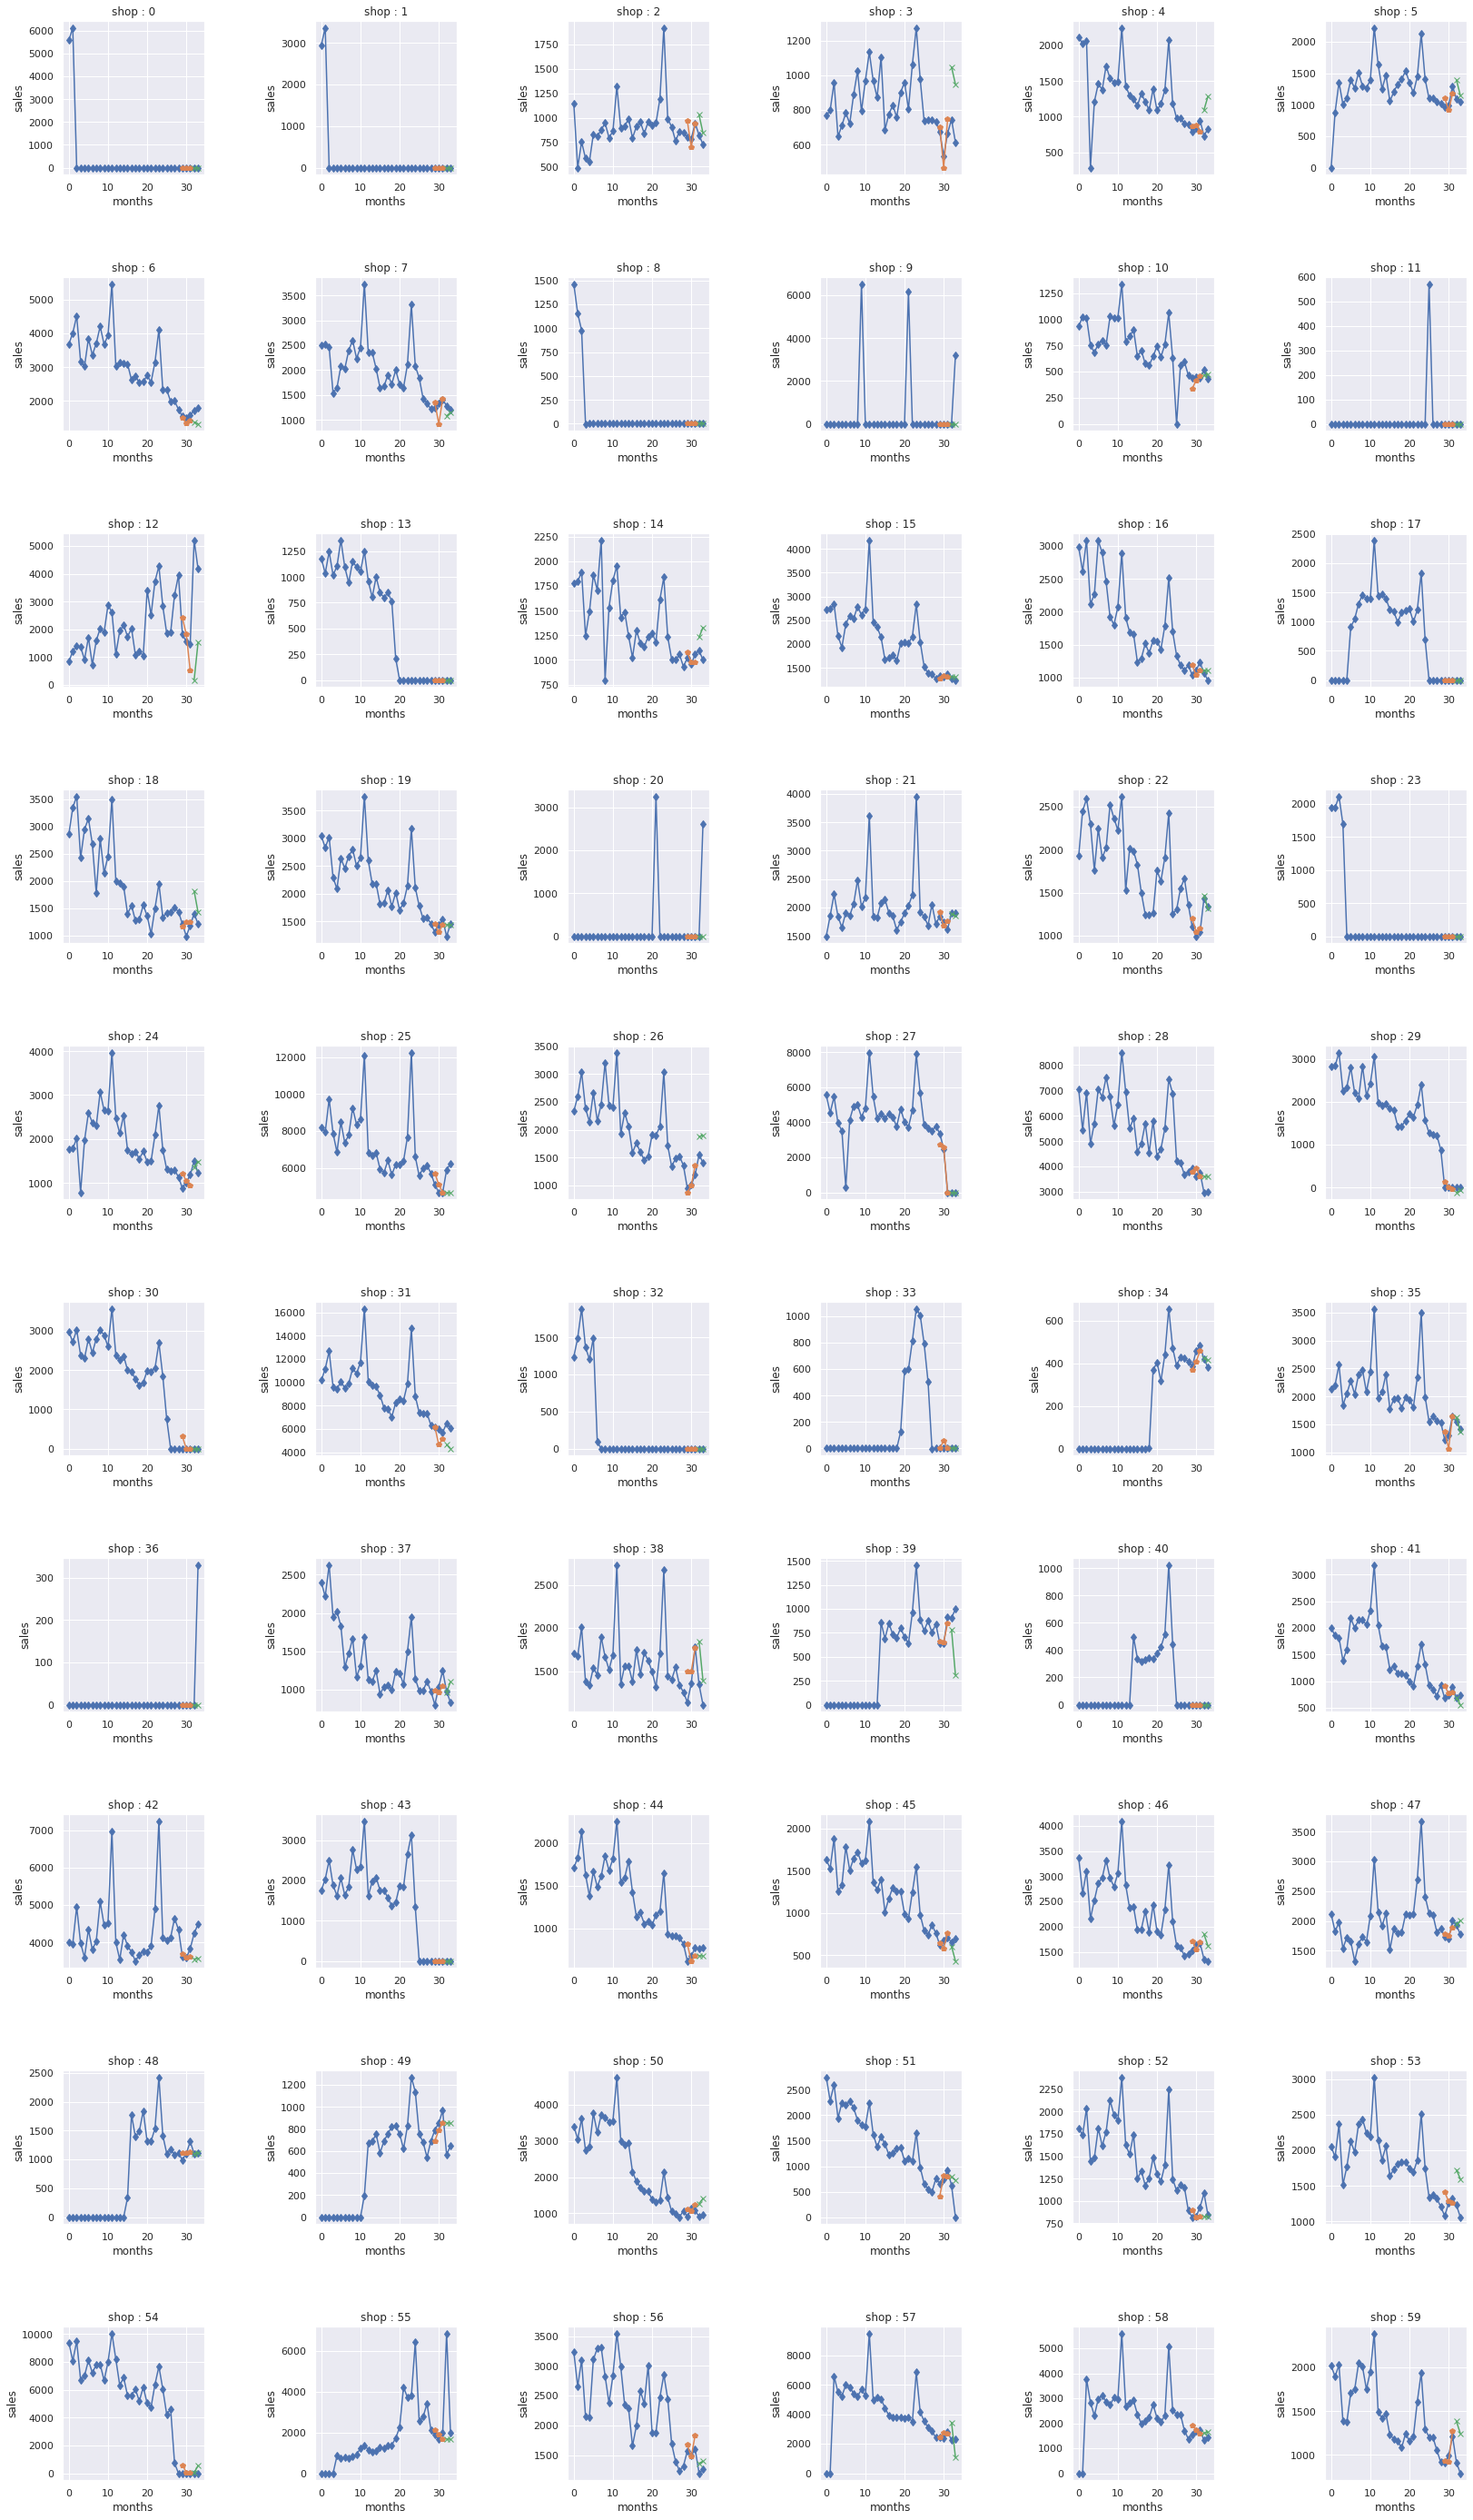

In [ ]:
# 60 shops vs 34 months
k = 4 # scale of plot
n, m = 10,6 # matrix of graphs
fig, axes = plt.subplots(n,m, figsize=(m*k,n*k))

x = MONTHS

shops_ARIMA = []

num_months = len(x)
for i,shop in enumerate(SHOPS):
  print(i,shop)
  y = np.zeros(num_months)
  y[gb_shops[shop].index] = gb_shops[shop].values

  y_train = y[:train_size]
  y_test = y[train_size : train_size + test_size]
  y_val = y[train_size + test_size : ]
  data = y[: train_size + test_size]

  # result, forecast = rolling_ARIMA(data=data,
  #                                  train_size=train_size,
  #                                  order = (6,2,0))

  result, forecast, _, order = optimised_ARIMA(data=data, 
                                               train_size=train_size, 
                                               order_range = ((6,12), #p
                                                              (0,1,2), #d
                                                              (0,3,6), #q
                                                              ), 
                                               metric=mean_squared_error, 
                                               model=rolling_ARIMA)

  y_test_pred = forecast
  y_val_pred  = result.predict(start = train_size + test_size,
                               end = num_months-1)
  shops_ARIMA.append(order)
  with open(SAVE_PATH+'shops.txt', 'a') as f:
    f.write(f'{i}\t{shop}\t{order}\n')

  ax = axes[i//m, i%m]
  ax.plot(x,y, 'd-')
  ax.plot(x_test, y_test_pred, 'p-')
  ax.plot(x_val, y_val_pred, 'x-')
  ax.set_title(f'shop : {shop} (p,d,q) = {order}')
  ax.set_xlabel('months')
  ax.set_ylabel('sales')

fig.tight_layout(pad=5)
plt.show()

# Model 3

In [ ]:
train_size = 29
test_size = 3
x = MONTHS
num_months = len(MONTHS)
x_train = x[:train_size]
x_test = x[train_size : train_size + test_size]
x_val = x[train_size + test_size : ]

cats_ARIMA_dic = {}
with open(SAVE_PATH+'Cat-Shop Models/all_cats.txt') as f:
  for line in f:
    _, i, order = line.strip().split('\t')
    i, order = int(i), eval(order)
    cats_ARIMA_dic[i] = order

shops_ARIMA_dic = {}
with open(SAVE_PATH+'Cat-Shop Models/all_shops.txt') as f:
  for line in f:
    _, i, order = line.strip().split('\t')
    i, order = int(i), eval(order)
    shops_ARIMA_dic[i] = order

items2cats_dic = df_cat[['item_id', 'item_category_id']].set_index('item_id').to_dict()['item_category_id']

In [ ]:
class model3_v1:
  def __init__(self, train_size, cats_ARIMA_dic, shops_ARIMA_dic):
    print('initialising..', end='\r')
    cat, shop = None, None

    self.cat_models = {}
    self.shop_models = {}

    for cat in cats_ARIMA_dic:
      print(f'initialising cat {cat}', end='')
      cat_order = cats_ARIMA_dic[cat]

      y = np.zeros(num_months)
      y[gb_cats[cat].index] = gb_cats[cat].values
      train = y[:train_size]
      model = ARIMA(train, order=cat_order)
      result = model.fit()

      self.cat_models[cat] = result
      print(end='\r')

    for shop in shops_ARIMA_dic:
      print(f'initialising shop {shop} ', end='')
      shop_order = shops_ARIMA_dic[shop]

      y = np.zeros(num_months)
      y[gb_shops[shop].index] = gb_shops[shop].values
      train = y[:train_size]
      model = ARIMA(train, order=shop_order)
      result = model.fit()

      self.shop_models[shop] = result
      print(end='\r')
    print('done')
  
  def predict(self, item, shop, start=34, end=34):

    cat = items2cats_dic[item]

    cat_model = self.cat_models[cat]
    shop_model = self.shop_models[shop]

    cat_pred = cat_model.predict(start=start, end=end)
    shop_pred = shop_model.predict(start=start, end=end)

    prediction = [max(i,j) for i,j in zip(cat_pred, shop_pred)] # core equation

    return prediction

In [ ]:
#initialise
model3 = model3_v1(train_size, cats_ARIMA_dic, shops_ARIMA_dic)

done


In [ ]:
df_test.shape

(214200, 3)

In [ ]:
#submission
ids = []
preds = []
d = 1e6
prin=False
num_rows = df_test.shape[0]

for id, shop, item in df_test.values:
  if id%d==0:
    prin = True
    print(f'{100*id/num_rows:.3f}% complete,{id},{shop},{item}', end='')
  preds += model3.predict(item, shop)
  ids.append(id)
  if prin:
    print(end='\r')

print('done')

df_submission = pd.DataFrame()
df_submission['ID'] = ids
df_submission['item_cnt_month'] = preds
print(df_submission.shape)
df_submission.head()

0.000% complete,0,5,5037
4.669% complete,10000,4,17015
9.337% complete,20000,3,1792
14.006% complete,30000,7,16813
18.674% complete,40000,12,9534
23.343% complete,50000,31,20196
28.011% complete,60000,25,11302
32.680% complete,70000,24,20517
37.348% complete,80000,15,4480
42.017% complete,90000,18,13647
46.685% complete,100000,19,4364
51.354% complete,110000,50,19118
56.022% complete,120000,53,18979
60.691% complete,130000,47,3919
65.359% complete,140000,57,8687
70.028% complete,150000,59,21842
74.697% complete,160000,56,8398
79.365% complete,170000,37,3028
84.034% complete,180000,38,16735
88.702% complete,190000,46,14390
93.371% complete,200000,44,10211
98.039% complete,210000,45,1239
(214200, 2)


,ID,item_cnt_month
0,0,4065.962660
1,1,5681.182667
2,2,4065.962660
3,3,2565.001192
4,4,5574.871243


In [115]:
df_submission.to_csv(SAVE_PATH+'submission_cat_shop1.csv', index=False)

# Submission Logs

|Sl.No.|Filename|Model|Score|Public Rank|
--- |---|---|---|---
|1|submission_cat_shop1.csv|max of cat and shop ARIMA|5076.96238|15485|
